In [49]:
from funk_svd import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

Using the [MovieLens 10M](https://grouplens.org/datasets/movielens/10m/) ratings file for comparison

In [2]:
df = pd.read_csv("data/movielens-10m-ratings.dat")
df.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [5]:
RNG_SEED = 6552
test_size = 0.3
df_train, df_valid = train_test_split(df,
                                     test_size=test_size, 
                                     random_state=RNG_SEED)

def unrepresented_fraction(label):
  unrepr_label = set(df_valid[label].unique()) - set(df_train[label].unique())
  len_total = len(df_valid)
  len_unrepr = len(df_valid[df_valid[label].isin(unrepr_label)])
  print(f"For label '{label}' there's a {len_unrepr/len_total*100:.4f}% of unrepresented",
        f"labels in validation set (total of {len_unrepr})")


# number of users and items not covered in train set (untrainable)
unrepresented_fraction("userId")
unrepresented_fraction("movieId")

For label 'userId' there's a 0.0000% of unrepresented labels in validation set (total of 0)
For label 'movieId' there's a 0.0025% of unrepresented labels in validation set (total of 74)


In [6]:
# drop unrepresented items, they're a tiny minority
print("rows before:",len(df_train), len(df_valid))
df_valid = df_valid[df_valid.movieId.isin(df_train.movieId.unique())]
assert set(df_valid.movieId.unique()) <= set(df_train.movieId.unique())
print("rows after",len(df_train), len(df_valid))

rows before: 7000037 3000017
rows after 7000037 2999943


In [42]:
# doing this for later visual inspection
df_train.head()

,userId,movieId,rating,timestamp
5558682,39689,55286,4.0,1207765403
1837122,13467,2761,5.0,950110817
8278964,59452,5952,5.0,1045889338
2445163,17747,8208,4.5,1199591770
2552517,18481,1939,3.0,1005516054


In [43]:
df_valid.head()

,userId,movieId,rating,timestamp
7894872,56641,1468,3.0,865785103
2201559,16049,231,2.0,840088503
9727275,69709,1188,2.0,988326852
9597683,68800,2959,4.0,1111488634
6808628,48680,1356,4.0,900824583


Now we need to make *userId* and *movieId* range from 0 to n-1 and m-1 respectively, otherwise map them

In [9]:
# check that users represent a contiguous segment from x to x+n
unique_users = df_train.userId.unique()
len(unique_users),unique_users.max() - unique_users.min() + 1 

(69878, 71567)

In [10]:
# check that items represent a contiguous segment from y to y+m
unique_items = df_train.movieId.unique()
len(unique_items),unique_items.max() - unique_items.min() + 1

(10631, 65133)

In [12]:
# lazy preprocessing
oe = OrdinalEncoder(dtype=int)

train_features = oe.fit_transform(df_train[["userId", "movieId"]])
valid_features = oe.transform(df_valid[["userId", "movieId"]])

train_features.max(axis=0), valid_features.max(axis=0)

(array([69877, 10630]), array([69877, 10630]))

In [41]:
R_train = pd.DataFrame(train_features, columns=["user","item"])
R_train["rating"] = df_train["rating"].reset_index(drop=True)
R_train.head()

,user,item,rating
0,38740,10010,4.0
1,13112,2675,5.0
2,58138,5845,5.0
3,17278,7677,4.5
4,17991,1854,3.0


In [44]:
R_valid = pd.DataFrame(valid_features, columns=["user","item"])
R_valid["rating"] = df_valid["rating"].reset_index(drop=True)
R_valid.head()

,user,item,rating
0,55378,1431,3.0
1,15628,228,2.0
2,68093,1164,2.0
3,67222,2873,4.0
4,47556,1326,4.0


In [46]:
# ultra baseline model
global_avg = R_train.rating.mean()

print(f"Global train-set rating mean is {global_avg}")

MSE_global_avg = np.mean((R_valid.rating - global_avg)**2)

print(f"Global avg has MSE: {MSE_global_avg:.3f}")

Global train-set rating mean is 3.512543505127187
Global avg has MSE: 1.125


In [68]:
# get MSE for baseline model that predicts rating with typical global+user_offset+item_offset
n = R_train.user.max() + 1
m = R_train.item.max() + 1 

# this is more numerically stable than incremental formula for average (with 1/n+1 coeff)
item_offsets = R_train.groupby("item").agg({"rating":"mean"}).rating.to_numpy() - global_avg
user_offsets = R_train.groupby("user").agg({"rating":"mean"}).rating.to_numpy() - global_avg

# estimate MSE as RSS/rows
RSS = 0
for user, item, rating in tqdm(R_valid.itertuples(index=False, name=None),total=len(R_valid)):
  prediction = global_avg + item_offsets[item] + user_offsets[user]
  RSS += (rating - prediction)**2

MSE_offsets = RSS / len(R_valid)
print(f"Offsets model has MSE: {MSE_offsets:.3f}")

100%|████████████████████████████████████████████████████████████████████| 2999943/2999943 [00:09<00:00, 324844.90it/s]

Offsets model has MSE: 0.786


In [76]:
%%time
# now the MF model with some random params
mf1 = FunkSVD(k=5, lda=0.3)

mf1.fit(
    R_train = R_train,
    R_valid = R_valid,
    rng_seed = RNG_SEED,
    min_iters = 4,
    max_iters = 10,
    mse_threshold = 0.02,
    debug = False
)

Wall time: 25min 10s


In [77]:
mf1.summary()

Nº iter		Loss(train)		MSE(valid)
   1		6231134.4451		   0.8167
   2		5709939.2988		   0.7738
   3		5389904.5376		   0.7282
   4		5137864.2093		   0.6927
   5		5012490.6534		   0.6777
   6		4951487.7723		   0.6723


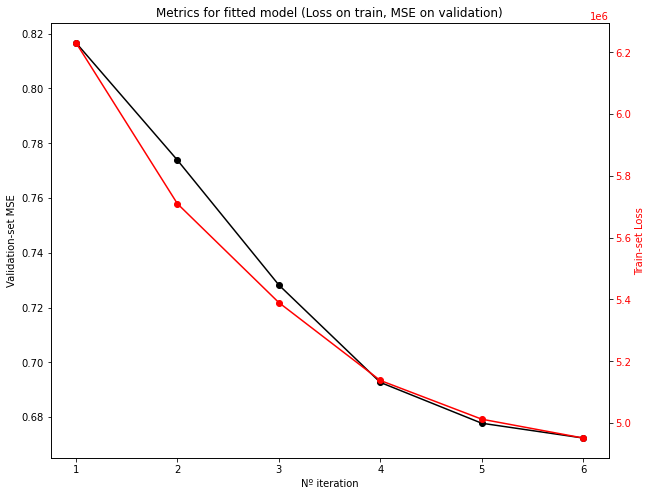

In [79]:
mf1.plot_metrics()
plt.show()

In [80]:
mf1._estimate_MSE(R_train)

Estimated RSS is 4110539.017
Estimated MSE is 0.587


0.5872167557472069

Some key insights:
* The model generalizes *very* well as MSE on train set is ~0.587 and MSE on validation set is ~0.672 with both curves having the expected shape for a well-behaving predictor
* It took only 2 rounds of ALS for this model to do better than the offsets one on the validation set
* Model fitting takes way too much time because of readability prioritization, making a multiprocessing-ready version with sharedmem-backed U and V may provide great improvements in this area (Numba at the time has too many support problems regarding dicts and lists -namely O_is and O_js-)